## Required Libraries

In [2]:
import os
import time
import pandas as pd
import numpy as np

# Modelling
import tensorflow as tf

import cv2
import mediapipe as mp

import sklearn
import matplotlib.pyplot as plt

This project is based on the work from this youtube https://www.youtube.com/watch?v=doDUihpj6ro&t=3540s

In [3]:
mp_holistic = mp.solutions.holistic         # Holistic model
mp_drawing = mp.solutions.drawing_utils     #Drawing utilites

In [4]:
def mediapipe_detection(image, model):

    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # Colour Conversion to RGB
    image.flags.writeable = False                       # Image is no longer writeable

    results = model.process(image)                      # Making prediction 

    image.flags.writeable = True                         # Image is now writeable
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR) # Converts back to BGR for video output

    return image, results

In [5]:
def draw_landmarks(image, results): # Draws the landmarks and the connections on the image.
    # Draw face connections
    mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_CONTOURS, 
                              mp_drawing.DrawingSpec(color=(80,110,10), thickness=1, circle_radius=1),  # dot colour
                              mp_drawing.DrawingSpec(color=(80,256,121), thickness=1, circle_radius=1)) # line colour

    # Draw pose connection     
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS,
                              mp_drawing.DrawingSpec(color=(80,22,10), thickness=2, circle_radius=4),  # dot colour
                              mp_drawing.DrawingSpec(color=(80,44,121), thickness=2, circle_radius=2)) # line colour

    # Draw left hand connections
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS,
                              mp_drawing.DrawingSpec(color=(121,22,76), thickness=2, circle_radius=4),  # dot colour
                              mp_drawing.DrawingSpec(color=(121,44,121), thickness=2, circle_radius=2)) # line colour  

    # Draw right hand connections
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS,
                              mp_drawing.DrawingSpec(color=(245,117,66), thickness=2, circle_radius=4),  # dot colour
                              mp_drawing.DrawingSpec(color=(8245,66,230), thickness=2, circle_radius=2)) # line colour 

In [6]:
capture = cv2.VideoCapture(1) #grab camera device default -- usually webcam -- device 0 is iphone and device 1 is macbook camera

#Set mediapipe model
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while capture.isOpened():     # if camera is available

        # Read frame
        return_, frame = capture.read()

        # Make detections
        image, results = mediapipe_detection(frame, holistic)

        # Draw results landmarks connections on image
        draw_landmarks(image, results)
        
        #Show the frame with the landmarks connections from image
        cv2.imshow("Feed", image)

        #break gracefully from the lopp
        if cv2.waitKey(1) & 0xFF == ord('q'): #& 0xFF operation ensures that the key code is compared correctly with the ASCII code of 'q' (ord('q')).
            break

    capture.release()
    cv2.destroyAllWindows()
    cv2.waitKey(1)

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


## Example what draw_landmarks function is doing

In [7]:
draw_landmarks(frame, results) # draw_landmarks function does not return result but apply results connection mapping on the image and save it

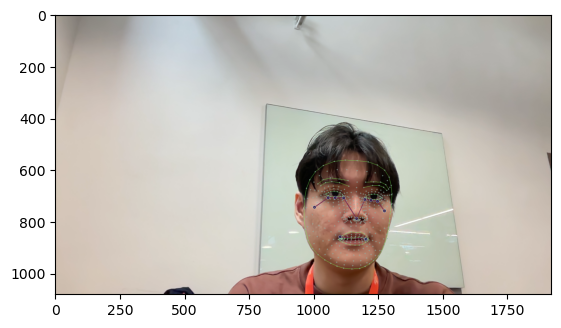

In [8]:
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

## Extract Keypoints Values 

### Converting keypoints values into arrays

In [9]:
def extract_keypoints(results):
    pose = np.array([[result.x, result.y, result.z, result.visibility] for result in results.pose_landmarks.landmark]).flatten() \
       if results.pose_landmarks else np.zeros(132) # z value represents the depth or distance of a particular landmark point in relation to the camera or reference point.
    
    face = np.array([[result.x, result.y, result.z] for result in results.face_landmarks.landmark]).flatten() \
            if results.face_landmarks else np.zeros(1404)
    
    # if no left hand is detected we will just insert zero array with shape (21*3) there are 21 points for hand and 3 coordinates
    left_hand = np.array([[result.x, result.y, result.z] for result in results.left_hand_landmarks.landmark]).flatten() \
            if results.left_hand_landmarks else np.zeros(21*3)

    right_hand = np.array([[result.x, result.y, result.z] for result in results.right_hand_landmarks.landmark]).flatten() \
            if results.right_hand_landmarks else np.zeros(21*3)
    
    return np.concatenate([pose, face, left_hand, right_hand])

In [10]:
result_test = extract_keypoints(results)

## Setup Folders for Collection of datasets

In [11]:
# Path for exported data, numpy arrays
Data_path = os.path.join('MP_Data')

# Actions that we try to detect
actions = np.array(['Hello', 'Thanks', 'ILoveYou'])
# Number of videos
num_sequences = 30
# Each video has 30 frames in length
sequence_length = 30

In [12]:
# Creating one folder for each action and in each folder there are 30 subfolder of 30 videos 
for action in actions:
    for sequence in range(num_sequences):
        try:
            os.makedirs(os.path.join(Data_path, action, str(sequence)))
        except:
            pass

## Collect Keypoint Values for Training and Testing

In [127]:
capture = cv2.VideoCapture(1) #grab camera device default -- usually webcam -- device 0 is iphone and device 1 is macbook camera

#Set mediapipe model
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    # Loop through actions
    for action in actions:
        #Loop thru num of videos
        for sequence in range(num_sequences):
           #Loop thru video length of 30 frames
            for frame_num in range(sequence_length):

                # Read frame
                return_, frame = capture.read()

                # Make detections
                image, results = mediapipe_detection(frame, holistic)

                # Draw results landmarks connections on image
                draw_landmarks(image, results)

                # Apply collection logic - printing text to show what actions and frames we can capturing
                if frame_num == 0:
                    cv2.putText(image, 'STARTING COLLECTION', (120,400),
                                cv2.FONT_HERSHEY_SIMPLEX, 2, (0,255,0), 4, cv2.LINE_AA)
                    cv2.putText(image, 'Collecting frames for {} Video Number {}'.format(action, sequence), (15,120),
                                cv2.FONT_HERSHEY_SIMPLEX, 1, (0,0,255), 4, cv2.LINE_AA) #Font type, font size, font colour, line weight and line type
                    #Show the frame with the landmarks connections from image
                    cv2.imshow("Feed", image)
                    cv2.waitKey(2000) # 1.5s break between each video
                else:
                    cv2.putText(image, 'Collecting frames for {} Video Number {}'.format(action, sequence), (15,120),
                                cv2.FONT_HERSHEY_SIMPLEX, 1, (0,0,255), 4, cv2.LINE_AA)
                    #Show the frame with the landmarks connections from image
                    cv2.imshow("Feed", image)
                    
                keypoints = extract_keypoints(results)
                npy_path = os.path.join(Data_path, action, str(sequence), str(frame_num))
                np.save(npy_path, keypoints)

                #break gracefully from the lopp
                if cv2.waitKey(10) & 0xFF == ord('q'): #& 0xFF operation ensures that the key code is compared correctly with the ASCII code of 'q' (ord('q')).
                    break

capture.release()
cv2.destroyAllWindows()
cv2.waitKey(1)

-1

## Preprocess Data and Create Labels and Features

In [128]:
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical

In [129]:
label_map = {label:num for num, label in enumerate(actions)}

In [130]:
label_map

{'Hello': 0, 'Thanks': 1, 'ILoveYou': 2}

In [133]:
sequences , labels = [], []
for action in actions:
    for sequence in range(num_sequences):
        window = []
        for frame_num in range(sequence_length):
            result = np.load(os.path.join(Data_path, action, str(sequence), "{}.npy".format(frame_num)))
            window.append(result)
        sequences.append(window)
        labels.append(label_map[action])

In [140]:
np.array(sequences).shape

(90, 30, 1662)

In [139]:
np.array(labels).shape

(90,)

In [141]:
X = np.array(sequences)
X.shape

(90, 30, 1662)

In [144]:
y = to_categorical(labels).astype(int)
y.shape

(90, 3)

In [155]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05)

In [156]:
y_test.shape

(5, 3)

## Build and Train LSTM Neural Network

In [13]:
from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.callbacks import TensorBoard

In [14]:
log_dir = os.path.join('Logs')
tb_callback = TensorBoard(log_dir=log_dir)

In [15]:
model = Sequential()
model.add(LSTM(64, return_sequences=True, activation='relu', input_shape=(30,1662)))
model.add(LSTM(128, return_sequences=True, activation='relu'))
model.add(LSTM(64, return_sequences=False, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(actions.shape[0], activation='softmax'))

In [160]:
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [161]:
model.fit(X_train, y_train, epochs=2000, callbacks=[tb_callback])

Epoch 1/2000
3/3 [==============================] - 2s 38ms/step - loss: 1.4122 - categorical_accuracy: 0.2706
Epoch 2/2000
3/3 [==============================] - 0s 40ms/step - loss: 4.6762 - categorical_accuracy: 0.2000
Epoch 3/2000
3/3 [==============================] - 0s 41ms/step - loss: 9.8081 - categorical_accuracy: 0.3529
Epoch 4/2000
3/3 [==============================] - 0s 40ms/step - loss: 10.5212 - categorical_accuracy: 0.2824
Epoch 5/2000
3/3 [==============================] - 0s 40ms/step - loss: 3.4661 - categorical_accuracy: 0.2353
Epoch 6/2000
3/3 [==============================] - 0s 39ms/step - loss: 1.9378 - categorical_accuracy: 0.4118
Epoch 7/2000
3/3 [==============================] - 0s 39ms/step - loss: 2.6502 - categorical_accuracy: 0.3059
Epoch 8/2000
3/3 [==============================] - 0s 43ms/step - loss: 2.3380 - categorical_accuracy: 0.2471
Epoch 9/2000
3/3 [==============================] - 0s 43ms/step - loss: 1.9309 - categorical_accuracy: 0.3294


KeyboardInterrupt: 

In [162]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 30, 64)            442112    
                                                                 
 lstm_4 (LSTM)               (None, 30, 128)           98816     
                                                                 
 lstm_5 (LSTM)               (None, 64)                49408     
                                                                 
 dense_3 (Dense)             (None, 64)                4160      
                                                                 
 dense_4 (Dense)             (None, 32)                2080      
                                                                 
 dense_5 (Dense)             (None, 3)                 99        
                                                                 
Total params: 596675 (2.28 MB)
Trainable params: 59667

## Make Predictions

In [175]:
res = model.predict(X_test)

1/1 [==============================] - 0s 179ms/step


In [176]:
actions[np.argmax(res[0])]

'ILoveYou'

In [177]:
actions[np.argmax(y_test[0])]

'ILoveYou'

In [170]:
model.save('Sign_language.h5')

/Users/kimrui/anaconda3/envs/kr_env/lib/python3.9/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [171]:
del model

In [16]:
model.load_weights('Sign_language.h5')

## Evaluation using Confusion Matrix and Accuracy

In [178]:
from sklearn.metrics import multilabel_confusion_matrix, accuracy_score

In [179]:
yhat =  model.predict(X_test)

1/1 [==============================] - 0s 16ms/step


In [180]:
ytrue = np.argmax(y_test, axis=1).tolist()
yhat = np.argmax(yhat, axis=1).tolist()

In [181]:
multilabel_confusion_matrix(ytrue, yhat)

array([[[3, 0],
        [0, 2]],

       [[2, 0],
        [0, 3]]])

In [182]:
accuracy_score(ytrue, yhat)

1.0

## Test in Real Time

In [17]:
colors = [(245,117,16),(117,245,16),(16,117,245)] #different colours for different actions

def prob_visualisation(res,actions, input_frame, colors):
    output_frame = input_frame.copy()
    for num, prob in enumerate(res):
        cv2.rectangle(output_frame, (0,60+num*40), (int(prob*100), 90+num*40), colors[num], -1) #-1 means fill in the rectangle
        cv2.putText(output_frame, actions[num], (0, 85+num*40), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)

    return output_frame

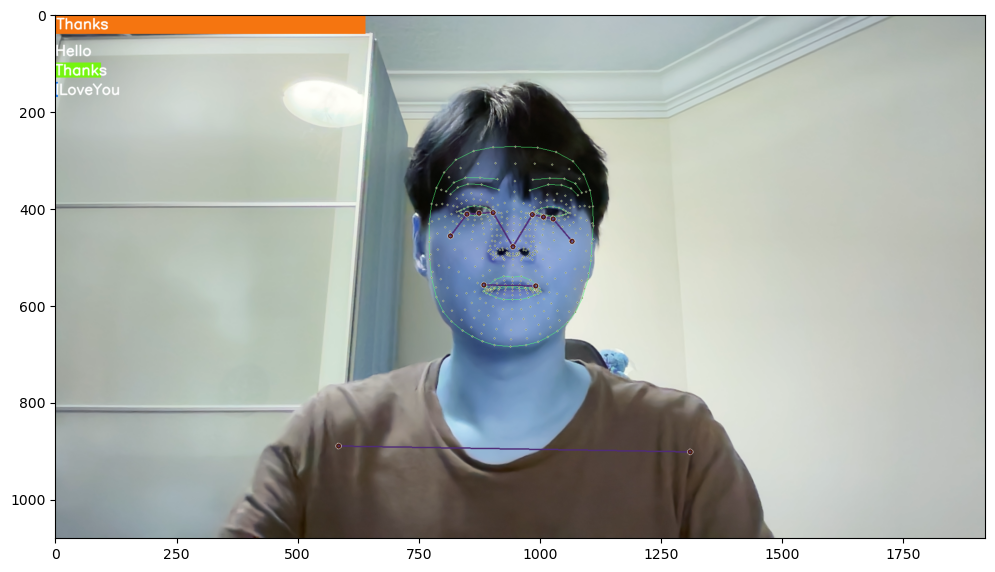

In [193]:
plt.figure(figsize=(12,12))
plt.imshow(prob_visualisation(res, actions, image, colors))

In [19]:
# Detection Variables
sequence = [] # concat the np frames (30 frames) and append to sequence as list to be processed by the model
sentence = []
predictions = []
threshold = 0.6 

capture = cv2.VideoCapture(1) #grab camera device default -- usually webcam -- device 0 is iphone and device 1 is macbook camera

#Set mediapipe model
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while capture.isOpened():     # if camera is available

        # Read frame
        return_, frame = capture.read()

        # Make detections
        image, results = mediapipe_detection(frame, holistic)

        # Draw results landmarks connections on image
        draw_landmarks(image, results)

        # Prediction logic
        keypoints = extract_keypoints(results)
        sequence.append(keypoints) #insert keypoints to the front of the sequence list
        sequence = sequence[-30:] #grab the last 30 frames

        if len(sequence) == 30: # only run predicts when the number of frames appended is 30
            res = model.predict(np.expand_dims(sequence, axis=0))[0] #we expand the dim to 'fake' a batch size dim, NxCxHxW expand in N dim
            # print(actions[np.argmax(res)])
            predictions.append(np.argmax(res))

            # Visualise the logic
            if np.unique(predictions[-10:])[0]==np.argmax(res):     # grab the last 10 predictions and checking if ten predictions are similar to each other and the current prediction
                if res[np.argmax(res)] > threshold:                 #checking the highest prediction probability > threshold
                    if len(sentence) > 0:                           #check if actions have already been predicted
                        if actions[np.argmax(res)] != sentence[-1]: # to check if the current action differs with the previous sentence
                            sentence.append(actions[np.argmax(res)])
                    else:
                        sentence.append(actions[np.argmax(res)])

            if len(sentence) > 1:
                sentence = sentence[-1:] #grab only the last 5 sentences

            # Visualise the probabilities
            image = prob_visualisation(res, actions, image, colors)

        cv2.rectangle(image, (0,0), (640, 40), (245, 117, 16), -1)
        cv2.putText(image, ' '.join(sentence), (3,30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
        
        #Show the frame with the landmarks connections from image
        cv2.imshow("Feed", image)

        #break gracefully from the lopp
        if cv2.waitKey(1) & 0xFF == ord('q'): #& 0xFF operation ensures that the key code is compared correctly with the ASCII code of 'q' (ord('q')).
            break

    capture.release()
    cv2.destroyAllWindows()
    cv2.waitKey(1)

1/1 [==============================] - 0s 10ms/step


: 